In [2]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [165]:
from sklearn.preprocessing import normalize
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

import scipy

In [6]:
plt.rcParams["figure.figsize"] = (15, 10)

## load data

In [7]:
pth_data = '../../data/train.csv'
df_origin = pd.read_csv(pth_data)

In [8]:
df_origin

,time,height,weight,gender,bmi,age,env_temp,rh,heart_rate,stress_level,skin_temp,eda,TC,TS,Clo,Act
0,2020-10-19 14:00:00,1.64,54.0,1,20.077335,24,77.990,62.122,60.0,17.0,NaN,NaN,4.0,4.0,0.74,1.0
1,2020-10-19 14:30:00,1.64,54.0,1,20.077335,24,78.208,62.321,78.0,60.0,30.748,0.926320,4.0,4.0,0.74,1.1
2,2020-10-19 15:00:00,1.64,54.0,1,20.077335,24,78.514,62.255,79.0,46.0,31.327,1.232405,4.0,4.0,0.74,1.1
3,2020-10-19 15:30:00,1.64,54.0,1,20.077335,24,79.041,61.491,94.0,91.0,31.458,0.375005,4.0,4.0,0.74,1.0
4,2020-10-19 16:00:00,1.64,54.0,1,20.077335,24,79.435,61.071,85.0,71.0,32.085,0.081127,4.0,4.0,0.74,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2791,2020-10-28 21:30:00,1.63,50.0,1,18.818924,23,76.528,40.530,73.0,22.0,31.850,0.114876,2.0,3.0,0.50,1.0
2792,2020-10-28 22:00:00,1.63,50.0,1,18.818924,23,76.876,39.890,70.5,10.0,32.215,0.146231,2.0,3.0,0.50,1.0
2793,2020-10-28 22:30:00,1.63,50.0,1,18.818924,23,77.050,39.710,72.0,5.0,32.656,0.153838,2.0,3.0,0.50,1.0
2794,2020-10-28 23:00:00,1.63,50.0,1,18.818924,23,76.703,39.980,66.0,0.0,31.902,0.160930,2.0,3.0,0.50,1.0


In [9]:
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2796 entries, 0 to 2795
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   time          2796 non-null   object 
 1   height        2796 non-null   float64
 2   weight        2796 non-null   float64
 3   gender        2796 non-null   int64  
 4   bmi           2796 non-null   float64
 5   age           2796 non-null   int64  
 6   env_temp      2796 non-null   float64
 7   rh            2796 non-null   float64
 8   heart_rate    2201 non-null   float64
 9   stress_level  1848 non-null   float64
 10  skin_temp     1874 non-null   float64
 11  eda           2396 non-null   float64
 12  TC            2717 non-null   float64
 13  TS            2712 non-null   float64
 14  Clo           2737 non-null   float64
 15  Act           2718 non-null   float64
dtypes: float64(13), int64(2), object(1)
memory usage: 349.6+ KB


## data process

### choose data: TS < 4.0
|Thermal Sensation（TS）	| |
|---|---|
|1|	Very uncomfortable|
|2|	Uncomfortable|
|3|	Slightly uncomfortable|
|4|	Neutral|
|5|	Slightly comfortable|
|6|	Comfortable|
|7|	Very comfortable|

In [61]:
df_origin[df_origin[['TS']].isna().TS].shape
# some na in clo, means unrecorded data

(84, 16)

In [62]:
df_ts_nona = df_origin[df_origin['TS'].isna() ^ True]

In [80]:
df_ts_nona.shape

(2712, 16)

In [81]:
df_ts_edge = df_ts_nona[df_ts_nona['TS'] < 4.0]

In [82]:
df_ts_edge.shape

(394, 16)

In [83]:
df_ts_edge.head()

,time,height,weight,gender,bmi,age,env_temp,rh,heart_rate,stress_level,skin_temp,eda,TC,TS,Clo,Act
50,2020-10-21 02:30:00,1.64,54.0,1,20.077335,24,78.427,61.044,81.0,7.0,32.552,0.169282,3.0,3.0,0.74,1.0
51,2020-10-21 03:00:00,1.64,54.0,1,20.077335,24,78.382,61.040,65.0,2.0,32.474,0.171619,3.0,3.0,0.74,1.0
52,2020-10-21 03:30:00,1.64,54.0,1,20.077335,24,78.121,60.745,NaN,0.0,32.889,0.177812,3.0,3.0,0.74,1.0
53,2020-10-21 04:00:00,1.64,54.0,1,20.077335,24,78.121,60.835,58.0,0.0,32.292,0.172982,3.0,2.0,0.74,1.0
62,2020-10-21 16:00:00,1.64,54.0,1,20.077335,24,77.945,61.636,70.0,20.0,32.059,0.263771,3.0,3.0,0.74,1.0


### choose data: TC < 4.0 
|Thermal Comfort（TC）|  |
|--|--|	
|1|	Very cool|
|2|	Cool|
|3|	Slight cool|
|4|	Neutral|
|5|	Slightly warm|
|6|	Warm|
|7|	Very warm|

In [84]:
df_ts_edge[df_ts_edge[['TC']].isna().TC].shape

(0, 16)

In [85]:
df_TC_nona = df_ts_edge[df_ts_edge['TC'].isna() ^ True]

In [86]:
df_TC_nona.shape

(394, 16)

In [87]:
df_comfort_edge_low = df_TC_nona[df_TC_nona['TC'] < 4.0]

In [89]:
df_comfort_edge_low = df_comfort_edge_low[df_comfort_edge_low['TC'] > 1.0]

In [90]:
df_comfort_edge_low.shape

(324, 16)

In [105]:
df_comfort = df_comfort_edge_low
df_comfort

,time,height,weight,gender,bmi,age,env_temp,rh,heart_rate,stress_level,skin_temp,eda,TC,TS,Clo,Act
50,2020-10-21 02:30:00,1.64,54.0,1,20.077335,24,78.427,61.044,81.0,7.0,32.552,0.169282,3.0,3.0,0.74,1.0
51,2020-10-21 03:00:00,1.64,54.0,1,20.077335,24,78.382,61.040,65.0,2.0,32.474,0.171619,3.0,3.0,0.74,1.0
52,2020-10-21 03:30:00,1.64,54.0,1,20.077335,24,78.121,60.745,NaN,0.0,32.889,0.177812,3.0,3.0,0.74,1.0
53,2020-10-21 04:00:00,1.64,54.0,1,20.077335,24,78.121,60.835,58.0,0.0,32.292,0.172982,3.0,2.0,0.74,1.0
62,2020-10-21 16:00:00,1.64,54.0,1,20.077335,24,77.945,61.636,70.0,20.0,32.059,0.263771,3.0,3.0,0.74,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2791,2020-10-28 21:30:00,1.63,50.0,1,18.818924,23,76.528,40.530,73.0,22.0,31.850,0.114876,2.0,3.0,0.50,1.0
2792,2020-10-28 22:00:00,1.63,50.0,1,18.818924,23,76.876,39.890,70.5,10.0,32.215,0.146231,2.0,3.0,0.50,1.0
2793,2020-10-28 22:30:00,1.63,50.0,1,18.818924,23,77.050,39.710,72.0,5.0,32.656,0.153838,2.0,3.0,0.50,1.0
2794,2020-10-28 23:00:00,1.63,50.0,1,18.818924,23,76.703,39.980,66.0,0.0,31.902,0.160930,2.0,3.0,0.50,1.0


### choose data: TC > 4.0 

In [92]:
df_comfort_edge_high = df_TC_nona[df_TC_nona['TC'] > 4.0]

In [94]:
df_comfort_edge_high = df_comfort_edge_high[df_comfort_edge_high['TC'] < 7.0]

In [95]:
df_comfort_edge_high.shape

(49, 16)

In [96]:
df_comfort_edge_high

,time,height,weight,gender,bmi,age,env_temp,rh,heart_rate,stress_level,skin_temp,eda,TC,TS,Clo,Act
85,2020-10-19 13:30:00,1.77,90.0,-1,28.727377,28,79.480,60.389,67.0,NaN,31.013,0.188456,6.0,3.0,0.36,1.1
86,2020-10-19 14:00:00,1.77,90.0,-1,28.727377,28,81.023,60.400,84.0,42.0,33.790,6.623951,6.0,2.0,0.36,1.1
87,2020-10-19 14:30:00,1.77,90.0,-1,28.727377,28,80.227,60.113,86.0,NaN,33.199,4.282520,6.0,2.0,0.36,1.1
88,2020-10-19 15:00:00,1.77,90.0,-1,28.727377,28,81.597,59.860,94.0,75.0,33.482,3.446370,6.0,2.0,0.36,1.1
112,2020-10-20 14:30:00,1.77,90.0,-1,28.727377,28,78.559,61.233,79.0,NaN,33.430,0.289664,6.0,3.0,0.57,1.4
113,2020-10-20 15:00:00,1.77,90.0,-1,28.727377,28,80.008,61.459,83.0,78.0,30.537,0.422045,6.0,3.0,0.57,1.7
114,2020-10-20 15:30:00,1.77,90.0,-1,28.727377,28,81.023,61.638,91.0,83.0,33.250,8.697113,6.0,3.0,0.36,1.1
128,2020-10-20 22:30:00,1.77,90.0,-1,28.727377,28,75.853,59.548,135.0,NaN,31.458,57.415932,5.0,3.0,0.36,3.8
205,2020-10-20 22:30:00,1.77,58.0,-1,18.513199,23,79.480,55.272,87.0,NaN,32.915,0.006857,5.0,3.0,0.36,1.0
416,2020-10-20 12:00:00,1.80,75.0,-1,23.148148,33,85.194,48.290,67.0,17.0,31.850,4.085208,6.0,3.0,0.31,1.0


### visualization

In [106]:
df_visual = df_comfort[['height', 'weight', 'gender', 'bmi', 'age', 'rh', \
                      'heart_rate', 'stress_level', 'skin_temp', 'eda', \
                      'Clo', 'Act', 'env_temp']]

In [107]:
df_visual.head()

,height,weight,gender,bmi,age,rh,heart_rate,stress_level,skin_temp,eda,Clo,Act,env_temp
50,1.64,54.0,1,20.077335,24,61.044,81.0,7.0,32.552,0.169282,0.74,1.0,78.427
51,1.64,54.0,1,20.077335,24,61.040,65.0,2.0,32.474,0.171619,0.74,1.0,78.382
52,1.64,54.0,1,20.077335,24,60.745,NaN,0.0,32.889,0.177812,0.74,1.0,78.121
53,1.64,54.0,1,20.077335,24,60.835,58.0,0.0,32.292,0.172982,0.74,1.0,78.121
62,1.64,54.0,1,20.077335,24,61.636,70.0,20.0,32.059,0.263771,0.74,1.0,77.945


#### pairplot
download it to zoom in

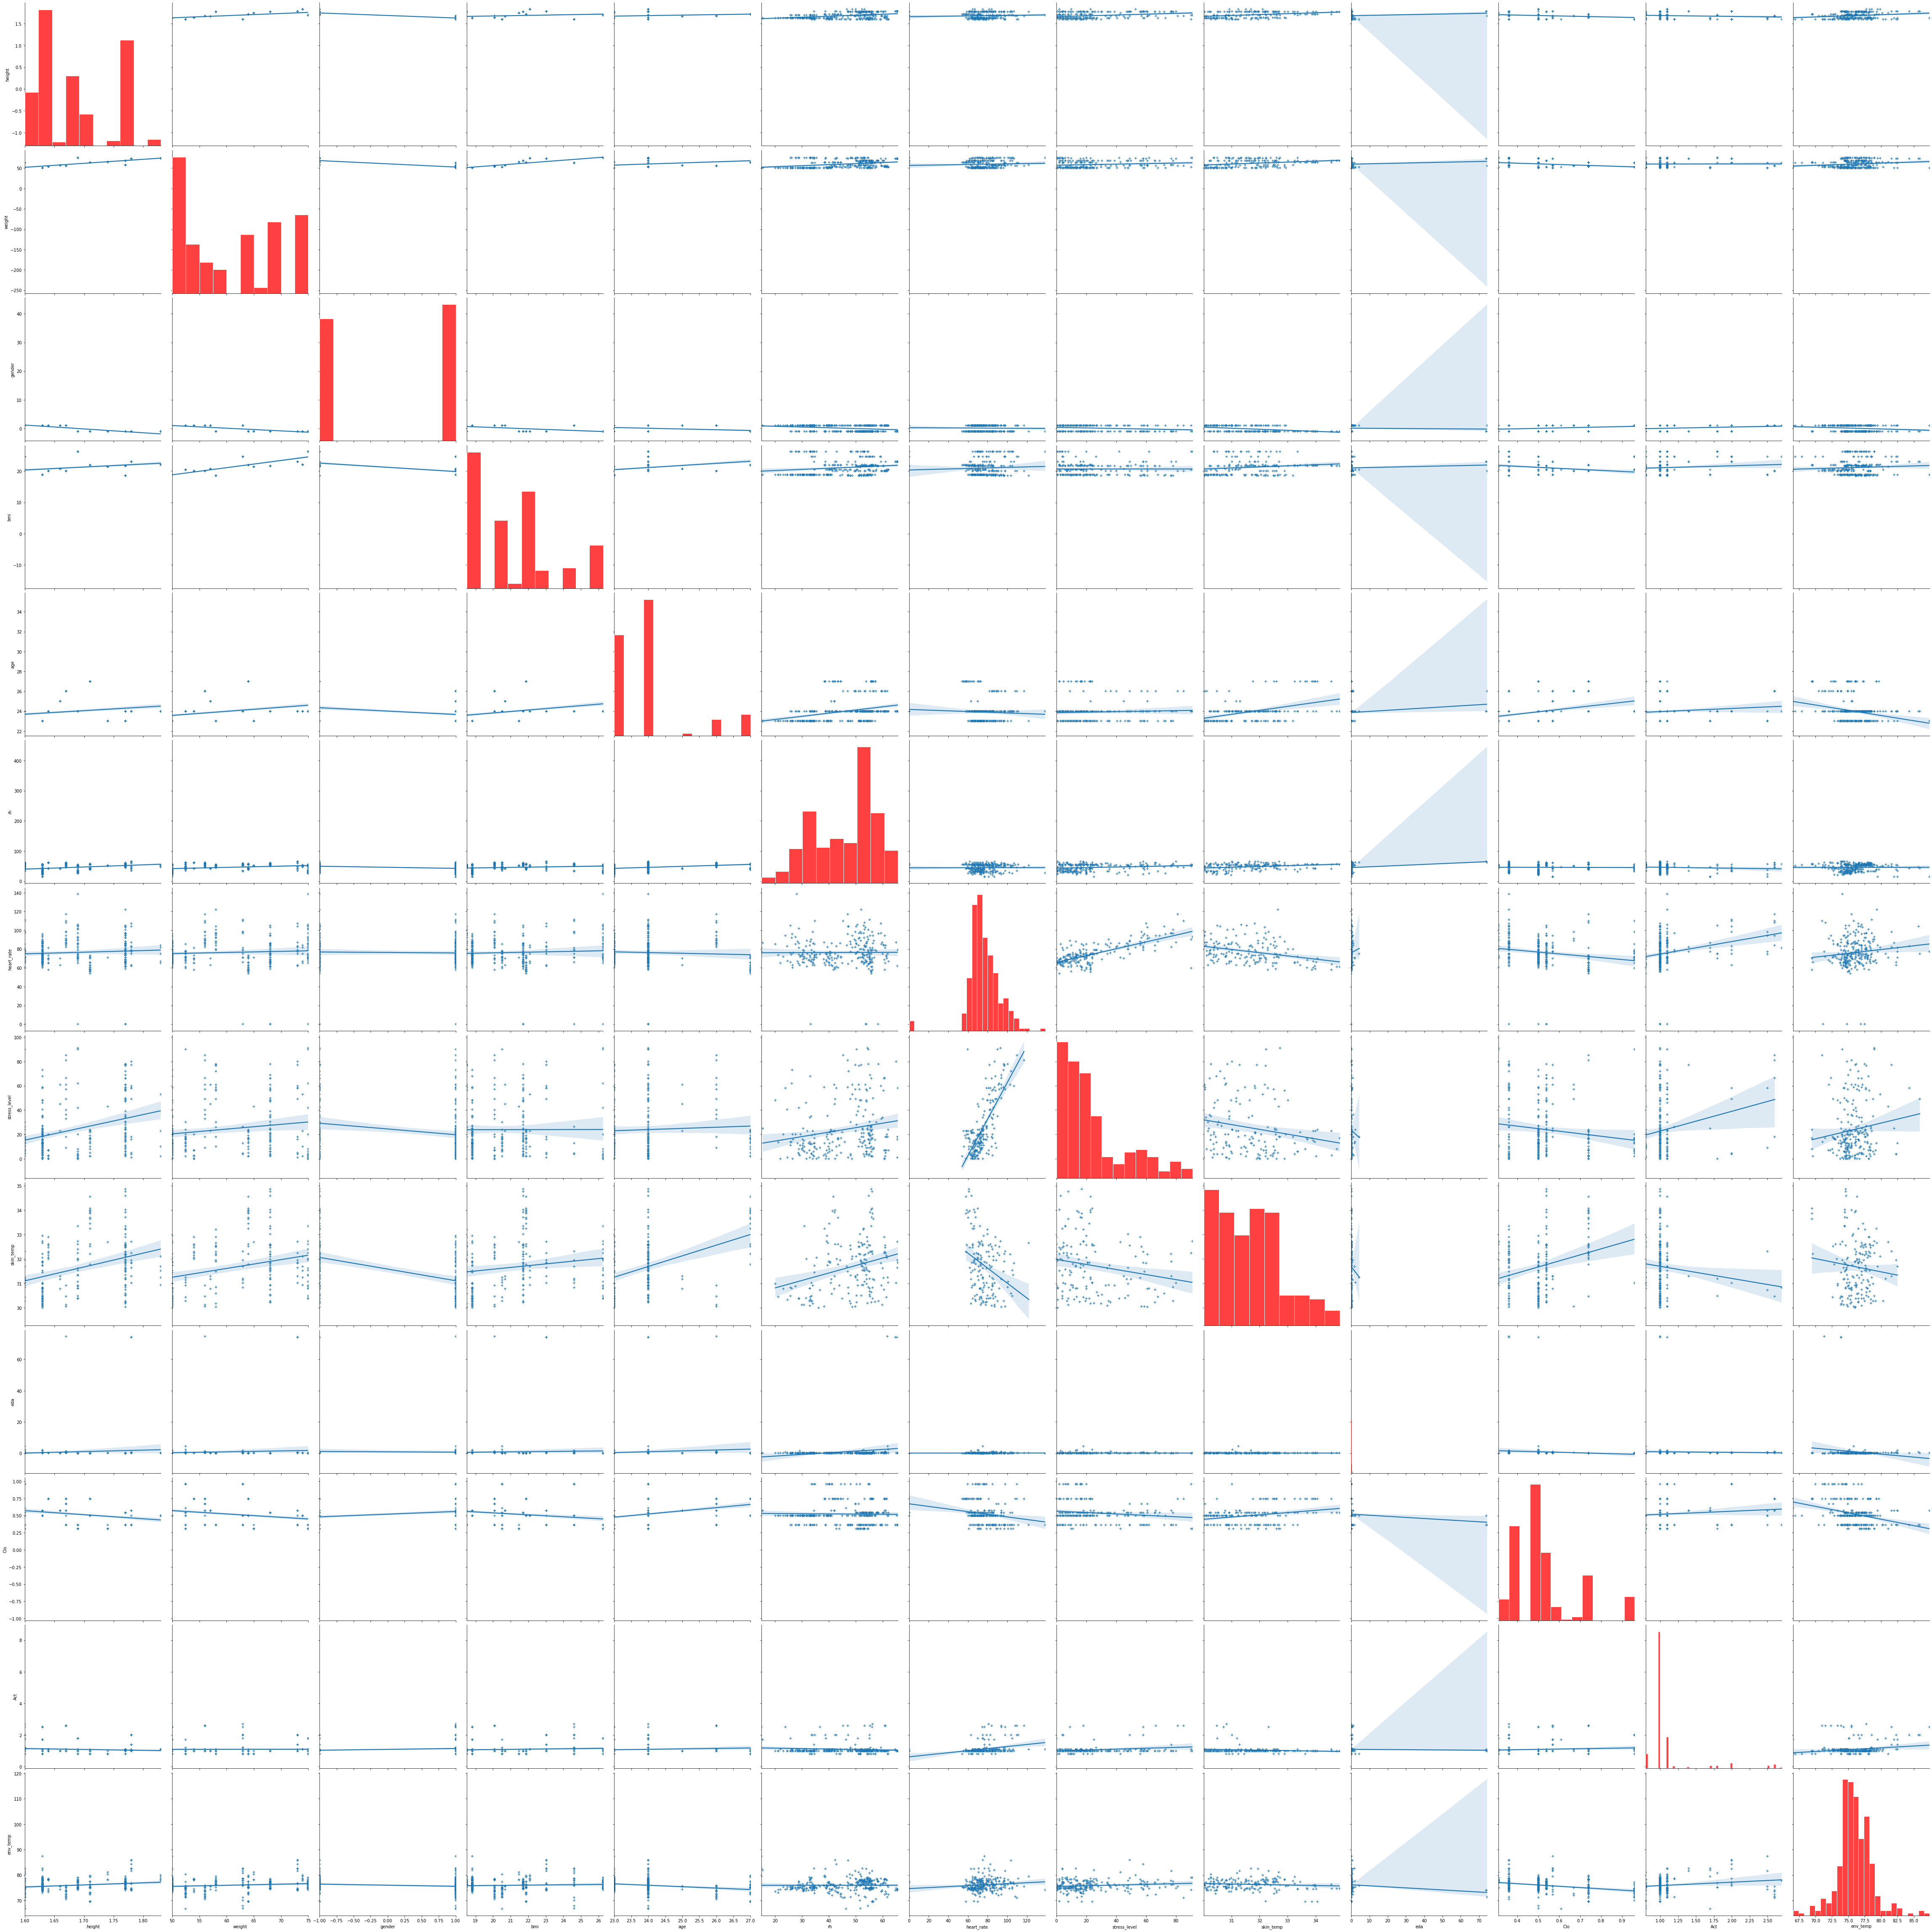

In [108]:
sns.pairplot(df_visual, dropna=True, kind='reg', markers='+', height=5, aspect=1,
            diag_kws=dict(edgecolor="w", color="r"))

#### correlation map

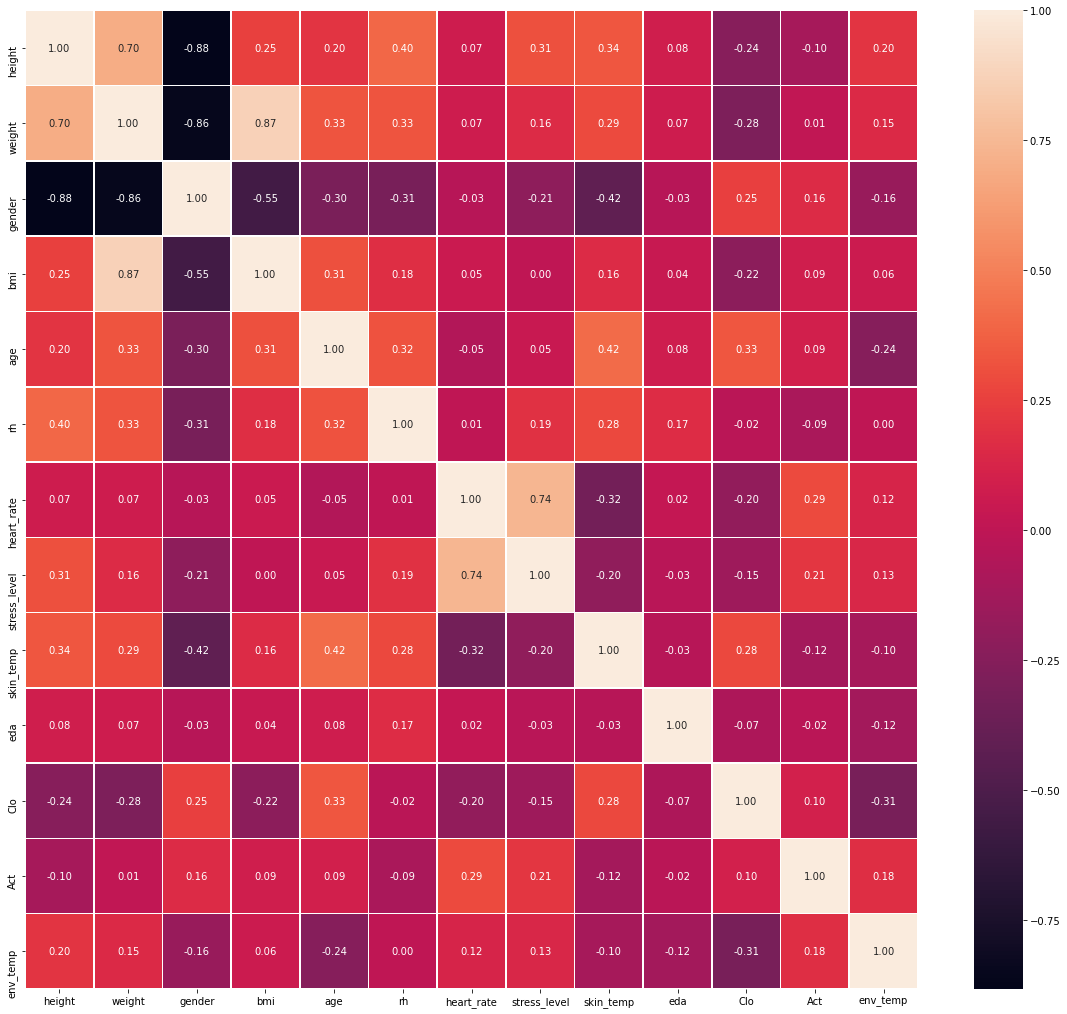

In [109]:
# correlation map
plt.rcParams["figure.figsize"] = (20, 18)
sns.heatmap(df_visual.corr(), annot=True, linewidths=.5, fmt= '.2f')
plt.show()

### shuffle

In [110]:
df_shuffle = df_comfort.sample(frac=1, random_state=1208).reset_index(drop=True)

In [111]:
X_data = df_shuffle[['height', 'weight', 'gender', 'bmi', 'age', 'rh', \
                      'heart_rate', 'stress_level', 'skin_temp', 'eda', \
                      'Clo', 'Act']]

In [112]:
X_cols_name = X_data.columns

In [113]:
y_data = df_shuffle['env_temp']

### imputation

In [114]:
df_comfort[df_comfort[['env_temp']].isna().env_temp]
# no na in env_temp

,time,height,weight,gender,bmi,age,env_temp,rh,heart_rate,stress_level,skin_temp,eda,TC,TS,Clo,Act


In [115]:
imp = SimpleImputer(strategy='mean')

In [116]:
X_data = pd.DataFrame(imp.fit_transform(X_data), columns=X_cols_name)

In [117]:
X_data_not_norm = pd.DataFrame(imp.fit_transform(X_data), columns=X_cols_name)

#### save data
for test use (imputated but not normalized data)

In [189]:
df_not_norm = pd.concat([X_data_not_norm, y_data], axis=1)

In [190]:
df_not_norm.to_csv('../processed_data/data_imputated_not_norm.csv', index=False)

In [191]:
df_not_norm

,height,weight,gender,bmi,age,rh,heart_rate,stress_level,skin_temp,eda,Clo,Act,env_temp
0,1.63,50.0,1.0,18.818924,23.0,39.890,70.500000,10.000000,32.215000,0.146231,0.50,1.0,76.876
1,1.74,65.0,-1.0,21.469150,23.0,51.680,76.298872,23.987342,31.672874,0.877379,0.36,1.0,80.206
2,1.77,68.0,-1.0,21.705129,24.0,55.748,66.000000,6.000000,33.353000,0.033414,0.54,1.0,74.467
3,1.63,50.0,1.0,18.818924,23.0,34.850,74.000000,20.000000,31.672874,0.068829,0.50,1.0,74.964
4,1.77,58.0,-1.0,18.513199,23.0,51.275,97.000000,76.500000,32.215000,0.006481,0.36,1.0,77.770
...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,1.78,73.0,-1.0,23.040020,24.0,65.400,76.298872,23.987342,31.672874,73.937247,0.50,1.0,73.926
320,1.69,75.0,-1.0,26.259585,24.0,31.690,70.000000,0.000000,32.007000,0.012316,0.36,1.0,74.791
321,1.69,75.0,-1.0,26.259585,24.0,25.660,105.000000,23.987342,30.484000,0.002907,0.36,1.8,75.139
322,1.71,64.0,-1.0,21.887076,27.0,42.280,59.000000,23.000000,33.996000,0.068711,0.74,1.0,75.484


### normalize
linear regression need this. random forest doesn't need

In [118]:
X_array_normalize, X_norm = normalize(X_data, axis=0, return_norm=True)

In [119]:
X_data = pd.DataFrame(X_array_normalize, columns=X_cols_name)

In [120]:
X_data

,height,weight,gender,bmi,age,rh,heart_rate,stress_level,skin_temp,eda,Clo,Act
0,0.053777,0.045653,0.055556,0.049077,0.053194,0.046726,0.050415,0.018183,0.056487,0.001136,0.050868,0.048122
1,0.057406,0.059349,-0.055556,0.055988,0.053194,0.060537,0.054562,0.043617,0.055536,0.006819,0.036625,0.048122
2,0.058395,0.062088,-0.055556,0.056604,0.055507,0.065302,0.047197,0.010910,0.058482,0.000260,0.054937,0.048122
3,0.053777,0.045653,0.055556,0.049077,0.053194,0.040823,0.052918,0.036367,0.055536,0.000535,0.050868,0.048122
4,0.058395,0.052958,-0.055556,0.048280,0.053194,0.060062,0.069366,0.139104,0.056487,0.000050,0.036625,0.048122
...,...,...,...,...,...,...,...,...,...,...,...,...
319,0.058725,0.066654,-0.055556,0.060085,0.055507,0.076608,0.054562,0.043617,0.055536,0.574616,0.050868,0.048122
320,0.055756,0.068480,-0.055556,0.068481,0.055507,0.037121,0.050058,0.000000,0.056122,0.000096,0.036625,0.048122
321,0.055756,0.068480,-0.055556,0.068481,0.055507,0.030058,0.075086,0.043617,0.053452,0.000023,0.036625,0.086620
322,0.056416,0.058436,-0.055556,0.057078,0.062445,0.049526,0.042191,0.041822,0.059610,0.000534,0.075284,0.048122


In [121]:
X_norm

array([  30.31058231, 1095.21561804,   18.        ,  383.45696797,
        432.37715018,  853.69505084, 1398.38738838,  549.95013699,
        570.3090419 ,  128.67248241,    9.82938452,   20.78051972])

## refine data

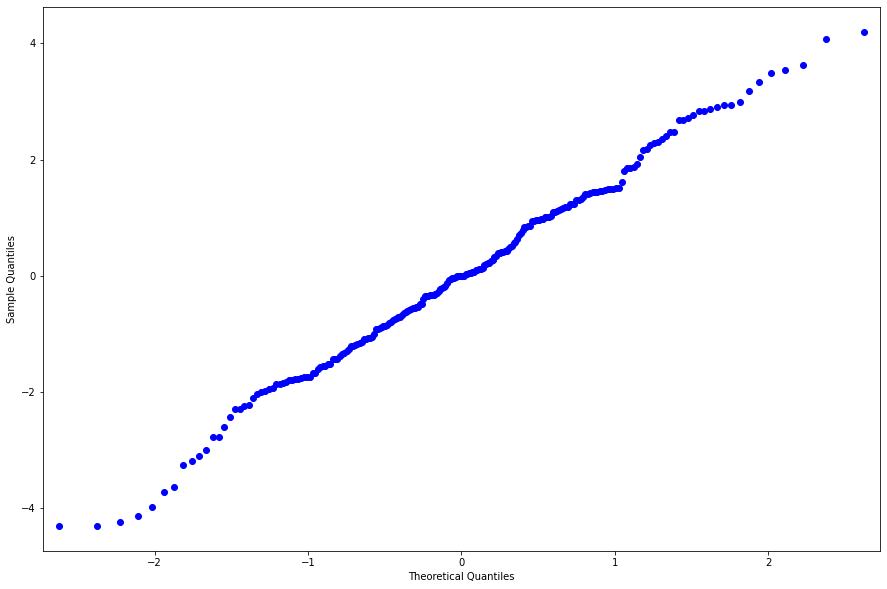

In [186]:
plt.rcParams["figure.figsize"] = (15, 10)
sm.qqplot(regr_fit.resid)
plt.show()

In [122]:
regr = sm.OLS(y_data, X_data)
regr_fit = regr.fit()

### leverage & outlier

In [124]:
infl = regr_fit.get_influence()

In [125]:
# leverage
leviers = infl.hat_matrix_diag
# list(leviers)

In [126]:
# studentized residue
res_studs = infl.resid_studentized_external
# list(res_studs)

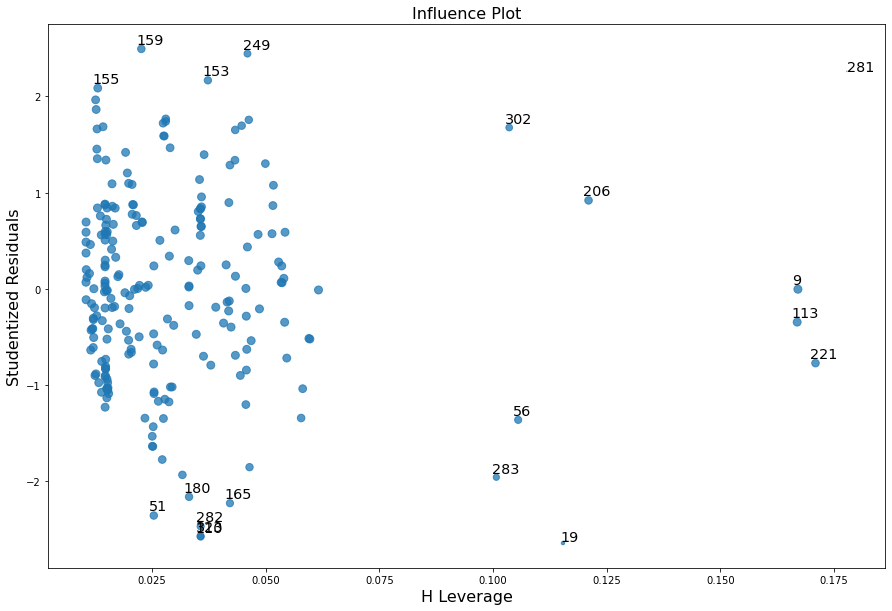

In [187]:
plt.rcParams["figure.figsize"] = (15, 10)
sm.graphics.influence_plot(regr_fit, size=0.5)
plt.show()

### leverage detection
the threshold value may be:
$$s_h=2\times \frac{p+1}{n}$$

In [127]:
n_data = X_data.shape[0]
p_data = X_data.shape[1]

In [128]:
s_h = 2 * (p_data + 1) / n_data
s_h

0.08024691358024691

In [129]:
atyp_levier = leviers > s_h

In [130]:
len(leviers[atyp_levier])

22

### outlier detection
Threshold:
$$s_t=t_{1-0.05/2}(n-p-2)$$

In [131]:
seuil_stud = scipy.stats.t.ppf(0.975, df=n_data-p_data-2)
seuil_stud

1.967645928777568

In [132]:
atyp_stud = np.abs(res_studs) > seuil_stud
atyp_stud

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False,  True, False, False, False, False, False, False, False,
       False,  True, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False,  True,  True, False,
       False, False,

In [133]:
idx_eliminate_lvg_outl = np.logical_not(np.logical_or(atyp_levier, atyp_stud))

In [134]:
X_data.index[idx_eliminate_lvg_outl]

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   9,  10,
            ...
            313, 314, 315, 316, 317, 318, 320, 321, 322, 323],
           dtype='int64', length=285)

In [135]:
X_data_refine = X_data[idx_eliminate_lvg_outl]
y_data_refine = y_data[idx_eliminate_lvg_outl]

### save refine data (not normalized)

In [136]:
X_data_refine_not_norm = X_data_not_norm[idx_eliminate_lvg_outl]
y_data_refine_not_norm = y_data[idx_eliminate_lvg_outl]

In [192]:
df_refine_not_norm = pd.concat([X_data_refine_not_norm, y_data_refine_not_norm], axis=1)

In [138]:
df_refine_not_norm.to_csv('../processed_data/train_refine_not_norm_min.csv', index=False)

In [139]:
df_refine_not_norm

,height,weight,gender,bmi,age,rh,heart_rate,stress_level,skin_temp,eda,Clo,Act,env_temp
0,1.63,50.0,1.0,18.818924,23.0,39.890,70.500000,10.000000,32.215000,0.146231,0.50,1.0,76.876
1,1.74,65.0,-1.0,21.469150,23.0,51.680,76.298872,23.987342,31.672874,0.877379,0.36,1.0,80.206
2,1.77,68.0,-1.0,21.705129,24.0,55.748,66.000000,6.000000,33.353000,0.033414,0.54,1.0,74.467
3,1.63,50.0,1.0,18.818924,23.0,34.850,74.000000,20.000000,31.672874,0.068829,0.50,1.0,74.964
4,1.77,58.0,-1.0,18.513199,23.0,51.275,97.000000,76.500000,32.215000,0.006481,0.36,1.0,77.770
...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,1.63,50.0,1.0,18.818924,23.0,55.330,65.000000,9.000000,31.672874,0.009863,0.50,0.8,76.703
320,1.69,75.0,-1.0,26.259585,24.0,31.690,70.000000,0.000000,32.007000,0.012316,0.36,1.0,74.791
321,1.69,75.0,-1.0,26.259585,24.0,25.660,105.000000,23.987342,30.484000,0.002907,0.36,1.8,75.139
322,1.71,64.0,-1.0,21.887076,27.0,42.280,59.000000,23.000000,33.996000,0.068711,0.74,1.0,75.484


## linear regression
try after refine

In [140]:
n_rows = y_data_refine.shape[0]

train_test_fraction = 0.8
n_rows_train = int(n_rows * train_test_fraction)
# n_rows_test = n_rows - n_rows_train

X_train = X_data_refine[:n_rows_train]
y_train = y_data_refine[:n_rows_train]

X_test = X_data_refine[n_rows_train:]
y_test = y_data_refine[n_rows_train:]

In [141]:
regr = sm.OLS(y_train, X_train)

In [142]:
regr_fit = regr.fit()

In [143]:
y_pred = regr_fit.predict(X_test)

In [144]:
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

,Actual,Predicted
260,74.446,75.113371
261,76.354,75.917832
262,75.659,75.693546
263,74.640,76.366278
264,74.791,77.278640
265,73.926,75.151441
266,77.029,76.609776
267,77.029,76.715763
269,72.718,74.713300
270,78.339,75.421172


In [145]:
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          4.044e+04
Date:                Mon, 30 Nov 2020   Prob (F-statistic):                        0.00
Time:                        22:07:27   Log-Likelihood:                         -430.76
No. Observations:                 228   AIC:                                      885.5
Df Residuals:                     216   BIC:                                      926.7
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height        1644.2378    102.223     16.085      0.000    1442.756    1845.720
weight        -710.9801     94.284     -7.541      0.000    -896.815    -525.146
gender           5.0715      6.377      0.795      0.427      -7.498      17.641
bmi            722.9085     82.315      8.782      0.000     560.666     885.151
age           -247.1723     58.476     -4.227      0.000    -362.429    -131.916
rh              32.9610     10.115      3.259      0.001      13.023      52.898
heart_rate      -6.5529     18.523     -0.354      0.724     -43.061      29.955
stress_level     0.0500      4.559      0.011      0.991      -8.937       9.037
skin_temp      -84.3084     83.752     -1.007      0.315    -249.384      80.767
eda              7.5643     35.714      0.212      0.832     -62.828      77.956
Clo            -34.0175      8.286     -4.105      0.000     -50.349     -17.686
Act             49.6820     17.661      2.813      0.005      14.872      84.492
==============================================================================
Omnibus:                        0.274   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.872   Jarque-Bera (JB):                0.100
Skew:                          -0.028   Prob(JB):                        0.951
Kurtosis:                       3.086   Cond. No.                         249.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [146]:
# mean squared error
mean_squared_error(y_test, y_pred)

3.060453189796678

In [147]:
# R2 score
r2_score(y_test, y_pred)

0.25832228277012304

## feature selection

### correlation map for refine data

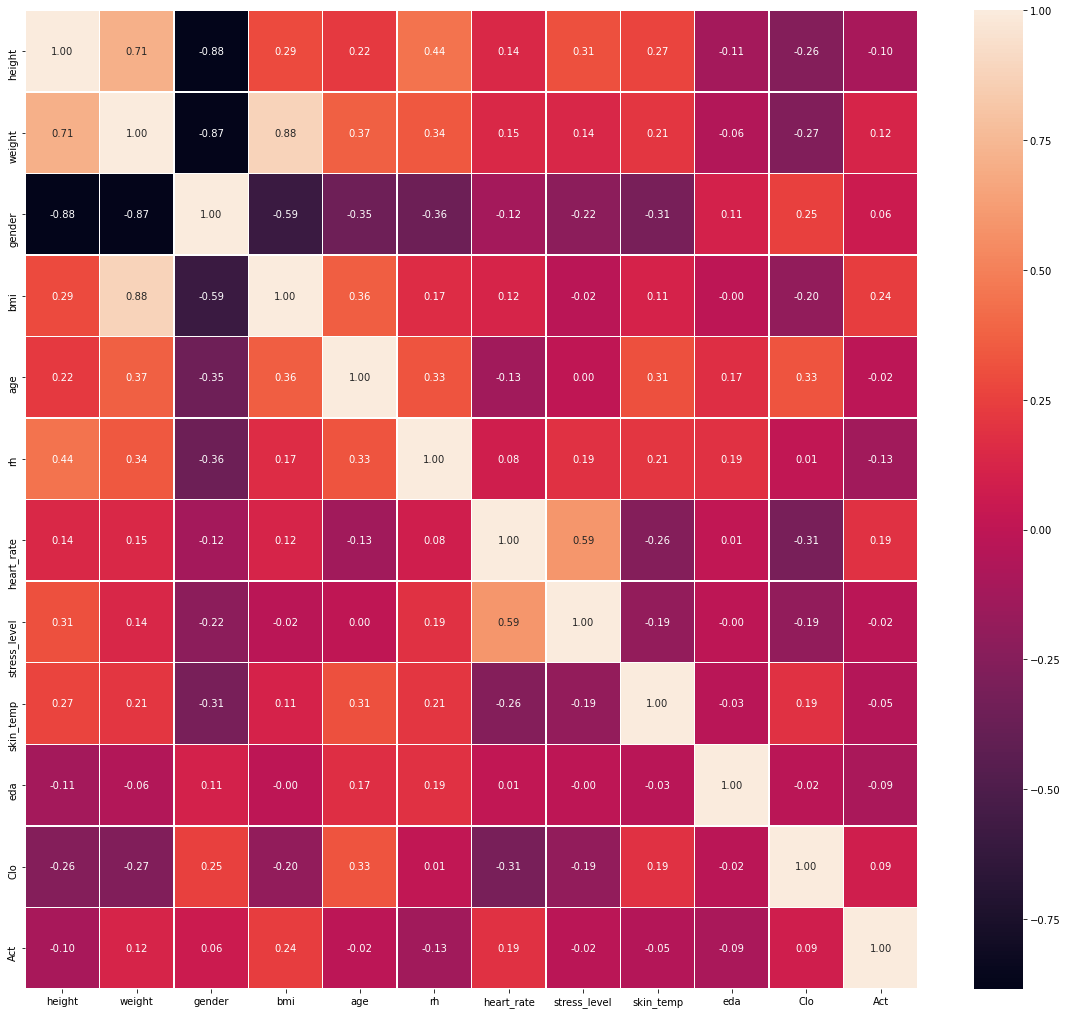

In [148]:
plt.rcParams["figure.figsize"] = (20, 18)
sns.heatmap(X_data_refine.corr(), annot=True, linewidths=.5, fmt= '.2f')
plt.show()

### backward selection

In [149]:
regr = sm.OLS(y_data_refine, X_data_refine)
regr_fit = regr.fit()

In [150]:
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          4.961e+04
Date:                Mon, 30 Nov 2020   Prob (F-statistic):                        0.00
Time:                        22:09:09   Log-Likelihood:                         -542.60
No. Observations:                 285   AIC:                                      1109.
Df Residuals:                     273   BIC:                                      1153.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height        1633.1094     91.573     17.834      0.000    1452.831    1813.388
weight        -725.1706     86.686     -8.365      0.000    -895.829    -554.512
gender           3.8844      5.762      0.674      0.501      -7.458      15.227
bmi            720.5060     74.159      9.716      0.000     574.509     866.503
age           -241.0070     51.074     -4.719      0.000    -341.556    -140.458
rh              37.1210      9.039      4.107      0.000      19.326      54.916
heart_rate     -22.7118     17.232     -1.318      0.189     -56.636      11.212
stress_level     0.7782      4.102      0.190      0.850      -7.298       8.854
skin_temp      -56.8294     76.117     -0.747      0.456    -206.680      93.021
eda              0.9578     34.351      0.028      0.978     -66.670      68.585
Clo            -35.7758      7.778     -4.600      0.000     -51.088     -20.464
Act             56.9038     13.704      4.152      0.000      29.925      83.882
==============================================================================
Omnibus:                        0.393   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.821   Jarque-Bera (JB):                0.289
Skew:                          -0.076   Prob(JB):                        0.866
Kurtosis:                       3.034   Cond. No.                         249.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [152]:
X_rm = X_data_refine

#### remove eda

In [153]:
X_rm = X_rm.drop(columns='eda')

In [154]:
regr = sm.OLS(y_data_refine, X_rm)
regr_fit = regr.fit()
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          5.432e+04
Date:                Mon, 30 Nov 2020   Prob (F-statistic):                        0.00
Time:                        22:10:18   Log-Likelihood:                         -542.60
No. Observations:                 285   AIC:                                      1107.
Df Residuals:                     274   BIC:                                      1147.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height        1632.8795     91.034     17.937      0.000    1453.664    1812.095
weight        -725.1676     86.528     -8.381      0.000    -895.512    -554.824
gender           3.8942      5.741      0.678      0.498      -7.407      15.195
bmi            720.5043     74.024      9.733      0.000     574.776     866.232
age           -240.7144     49.893     -4.825      0.000    -338.937    -142.491
rh              37.1744      8.818      4.216      0.000      19.815      54.533
heart_rate     -22.7012     17.196     -1.320      0.188     -56.555      11.152
stress_level     0.7770      4.094      0.190      0.850      -7.284       8.838
skin_temp      -56.8753     75.960     -0.749      0.455    -206.415      92.664
Clo            -35.8083      7.676     -4.665      0.000     -50.920     -20.697
Act             56.8750     13.640      4.170      0.000      30.023      83.727
==============================================================================
Omnibus:                        0.398   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.819   Jarque-Bera (JB):                0.292
Skew:                          -0.076   Prob(JB):                        0.864
Kurtosis:                       3.035   Cond. No.                         249.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### remove stress_level

In [155]:
X_rm = X_rm.drop(columns='stress_level')

In [156]:
regr = sm.OLS(y_data_refine, X_rm)
regr_fit = regr.fit()
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          5.996e+04
Date:                Mon, 30 Nov 2020   Prob (F-statistic):                        0.00
Time:                        22:11:03   Log-Likelihood:                         -542.62
No. Observations:                 285   AIC:                                      1105.
Df Residuals:                     275   BIC:                                      1142.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
height      1634.2528     90.587     18.041      0.000    1455.921    1812.585
weight      -724.6381     86.331     -8.394      0.000    -894.592    -554.684
gender         3.8496      5.726      0.672      0.502      -7.422      15.121
bmi          719.1521     73.551      9.778      0.000     574.358     863.946
age         -239.8020     49.574     -4.837      0.000    -337.395    -142.209
rh            37.2660      8.789      4.240      0.000      19.964      54.568
heart_rate   -20.8966     14.302     -1.461      0.145     -49.053       7.260
skin_temp    -59.5077     74.552     -0.798      0.425    -206.272      87.257
Clo          -35.7809      7.661     -4.670      0.000     -50.863     -20.699
Act           56.7115     13.589      4.173      0.000      29.960      83.463
==============================================================================
Omnibus:                        0.407   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.816   Jarque-Bera (JB):                0.292
Skew:                          -0.076   Prob(JB):                        0.864
Kurtosis:                       3.041   Cond. No.                         241.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### remove gender

In [157]:
X_rm = X_rm.drop(columns='gender')

In [158]:
regr = sm.OLS(y_data_refine, X_rm)
regr_fit = regr.fit()
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          6.676e+04
Date:                Mon, 30 Nov 2020   Prob (F-statistic):                        0.00
Time:                        22:11:37   Log-Likelihood:                         -542.85
No. Observations:                 285   AIC:                                      1104.
Df Residuals:                     276   BIC:                                      1137.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
height      1657.6091     83.578     19.833      0.000    1493.077    1822.141
weight      -775.0422     42.770    -18.121      0.000    -859.238    -690.846
bmi          756.1928     48.681     15.533      0.000     660.359     852.027
age         -244.5368     49.023     -4.988      0.000    -341.042    -148.031
rh            38.4831      8.592      4.479      0.000      21.569      55.397
heart_rate   -21.6647     14.243     -1.521      0.129     -49.703       6.373
skin_temp    -67.2542     73.583     -0.914      0.362    -212.109      77.601
Clo          -35.7388      7.653     -4.670      0.000     -50.805     -20.673
Act           58.7134     13.245      4.433      0.000      32.638      84.788
==============================================================================
Omnibus:                        0.673   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.714   Jarque-Bera (JB):                0.478
Skew:                          -0.087   Prob(JB):                        0.787
Kurtosis:                       3.099   Cond. No.                         197.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### remove skin_temp

In [159]:
X_rm = X_rm.drop(columns='skin_temp')

In [160]:
regr = sm.OLS(y_data_refine, X_rm)
regr_fit = regr.fit()
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          7.515e+04
Date:                Mon, 30 Nov 2020   Prob (F-statistic):                        0.00
Time:                        22:12:11   Log-Likelihood:                         -543.28
No. Observations:                 285   AIC:                                      1103.
Df Residuals:                     277   BIC:                                      1132.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
height      1593.3501     45.180     35.267      0.000    1504.411    1682.289
weight      -749.1769     32.059    -23.369      0.000    -812.287    -686.067
bmi          730.2947     39.574     18.454      0.000     652.391     808.198
age         -249.6890     48.683     -5.129      0.000    -345.525    -153.853
rh            38.1080      8.580      4.442      0.000      21.218      54.998
heart_rate   -18.0915     13.691     -1.321      0.187     -45.044       8.861
Clo          -36.6264      7.589     -4.826      0.000     -51.566     -21.687
Act           58.6707     13.241      4.431      0.000      32.604      84.737
==============================================================================
Omnibus:                        0.754   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.686   Jarque-Bera (JB):                0.576
Skew:                          -0.102   Prob(JB):                        0.750
Kurtosis:                       3.081   Cond. No.                         113.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### remove heart_rate

In [161]:
X_rm = X_rm.drop(columns='heart_rate')

In [162]:
regr = sm.OLS(y_data_refine, X_rm)
regr_fit = regr.fit()
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          8.565e+04
Date:                Mon, 30 Nov 2020   Prob (F-statistic):                        0.00
Time:                        22:14:01   Log-Likelihood:                         -544.18
No. Observations:                 285   AIC:                                      1102.
Df Residuals:                     278   BIC:                                      1128.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
height      1572.5385     42.402     37.086      0.000    1489.068    1656.009
weight      -739.8976     31.322    -23.622      0.000    -801.557    -678.238
bmi          721.0592     39.004     18.487      0.000     644.279     797.840
age         -244.4217     48.585     -5.031      0.000    -340.062    -148.781
rh            36.8285      8.536      4.314      0.000      20.024      53.633
Clo          -34.0811      7.350     -4.637      0.000     -48.551     -19.612
Act           54.8492     12.939      4.239      0.000      29.378      80.320
==============================================================================
Omnibus:                        0.378   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.828   Jarque-Bera (JB):                0.220
Skew:                          -0.056   Prob(JB):                        0.896
Kurtosis:                       3.077   Cond. No.                         103.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## linear regression (final try)

### single linear regression

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X_rm, y_data_refine, test_size=0.2, random_state=1208)

In [171]:
n_features = X_train.shape[1]

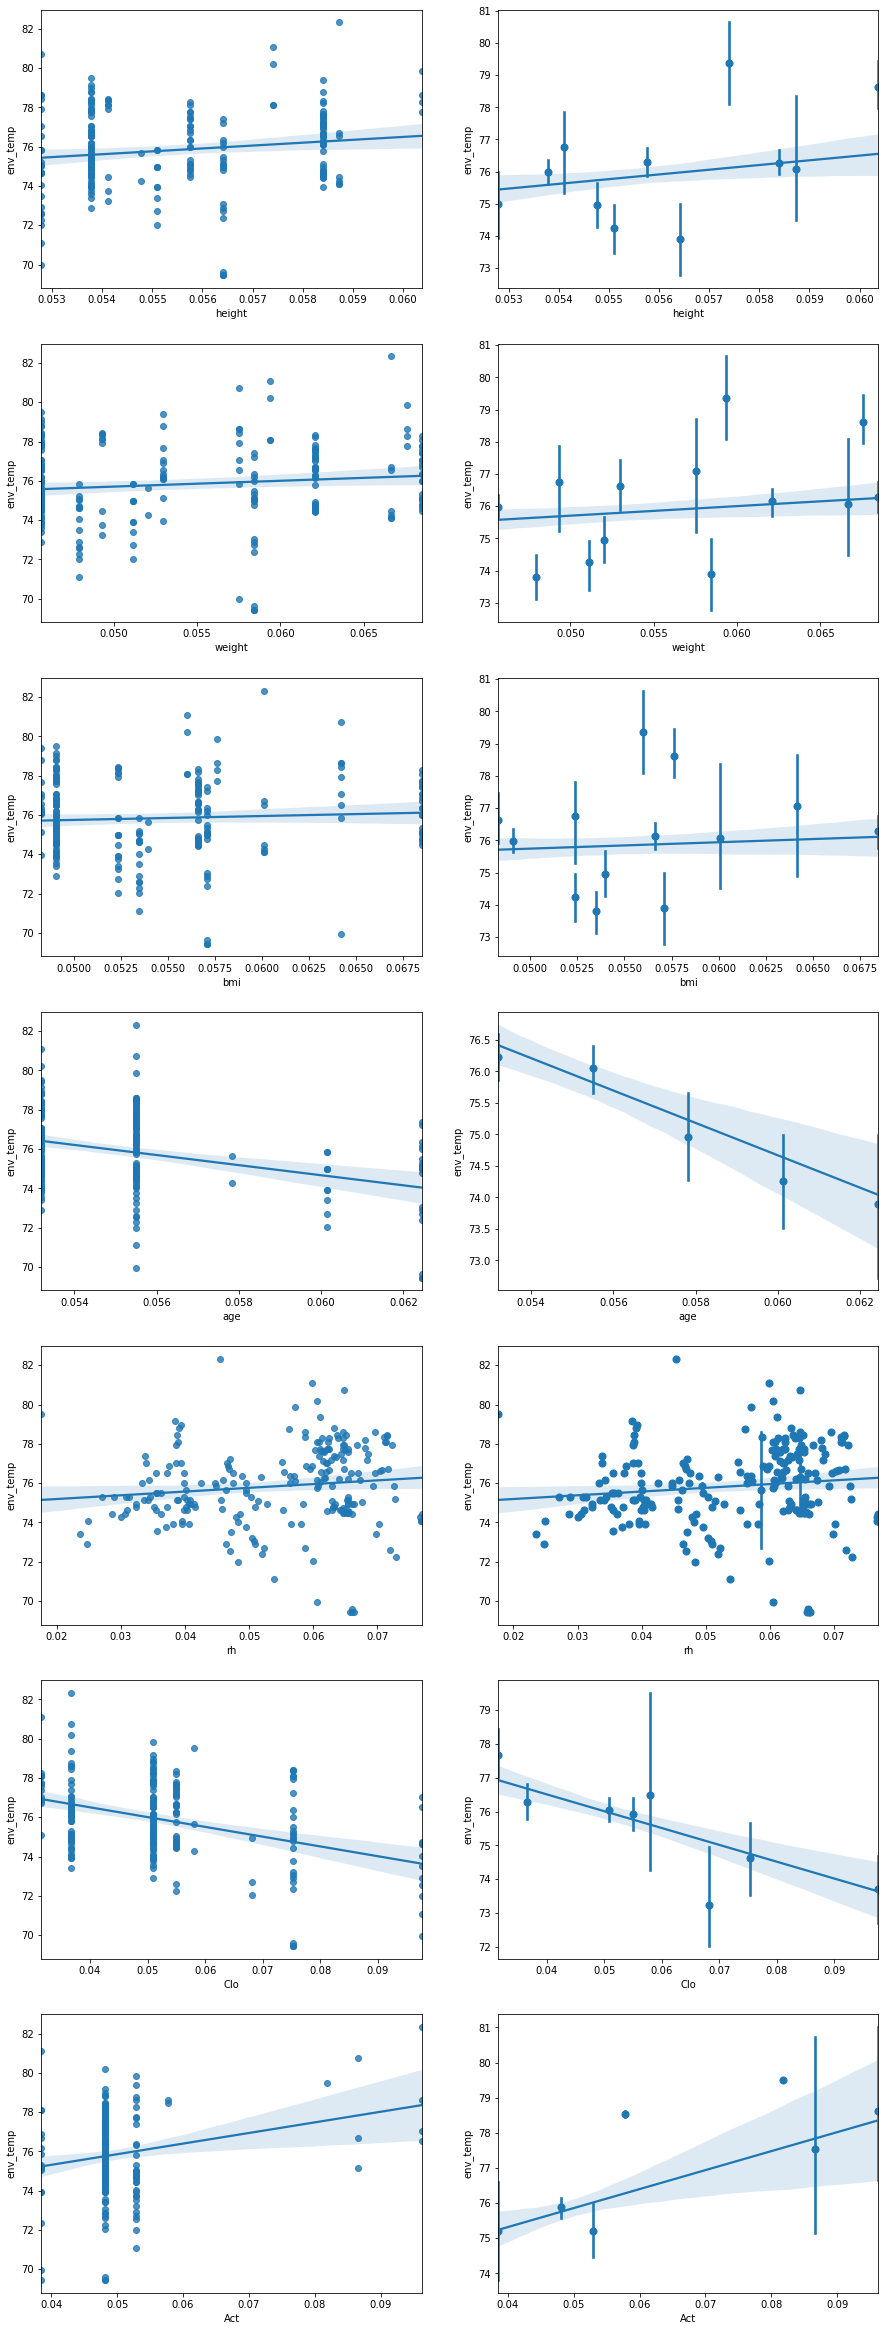

In [172]:
plt.figure(figsize=(15, 6*n_features))
i = 1
for col_n in X_train.columns:
    # left
    plt.subplot(n_features, 2, i)
    sns.regplot(x=X_train[col_n], y=y_train)
    i += 1
    
    # right
    plt.subplot(n_features, 2, i)
    sns.regplot(x=X_train[col_n], y=y_train, x_estimator=np.mean)
    i += 1

### multiple linear regression

In [173]:
regr = sm.OLS(y_train, X_train)

In [174]:
regr_fit = regr.fit()

In [175]:
y_pred = regr_fit.predict(X_test)

In [176]:
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

,Actual,Predicted
190,78.514,76.336850
30,79.502,76.146083
261,76.354,75.911340
247,74.964,75.842281
13,76.528,76.407240
81,74.619,75.894009
116,76.181,76.291898
175,73.407,75.651560
167,76.375,76.196639
271,77.509,78.098346


In [177]:
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          6.325e+04
Date:                Mon, 30 Nov 2020   Prob (F-statistic):                        0.00
Time:                        22:21:48   Log-Likelihood:                         -443.79
No. Observations:                 228   AIC:                                      901.6
Df Residuals:                     221   BIC:                                      925.6
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
height      1584.0290     47.586     33.288      0.000    1490.249    1677.809
weight      -746.6831     35.705    -20.912      0.000    -817.049    -676.317
bmi          730.8284     43.836     16.672      0.000     644.437     817.219
age         -260.2586     54.520     -4.774      0.000    -367.704    -152.813
rh            31.3591      9.995      3.137      0.002      11.661      51.057
Clo          -32.5461      8.584     -3.791      0.000     -49.464     -15.629
Act           61.1175     14.298      4.275      0.000      32.939      89.295
==============================================================================
Omnibus:                        0.208   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.901   Jarque-Bera (JB):                0.313
Skew:                          -0.063   Prob(JB):                        0.855
Kurtosis:                       2.870   Cond. No.                         99.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [178]:
# mean squared error
mean_squared_error(y_test, y_pred)

1.9129210683724347

In [179]:
# R2 score
r2_score(y_test, y_pred)

0.30209734238767927

## cross validation

In [180]:
from sklearn import metrics
# metrics
sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [181]:
lr = LinearRegression()
lr_cv_mse = cross_val_score(lr, X_rm, y_data_refine, scoring='neg_mean_squared_error', cv=10)

In [182]:
lr_cv_mse

array([-2.08570977, -2.32583038, -2.35181834, -2.9051045 , -3.70681178,
       -3.02186378, -2.06571385, -3.07018312, -3.23067455, -2.87571208])

In [183]:
np.abs(lr_cv_mse.mean())

2.7639422153249917

In [184]:
lr_cv_r2 = cross_val_score(lr, X_rm, y_data_refine, scoring='r2', cv=10)

In [185]:
lr_cv_r2.mean()

0.23905805754946732